In [50]:
import os

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [143]:
import math
from pathlib import Path

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import torch
from rich import print as rprint
from safetensors import safe_open
from scipy.spatial import procrustes
from sklearn.decomposition import PCA
from torch.linalg import inv, matrix_power, pinv
from torch.utils.data import DataLoader, Subset
from torcheval.metrics import MulticlassAccuracy
from tqdm import tqdm

from analysis.utils import load_autoencoder, load_model, scatter
from koopmann import aesthetics
from koopmann.aesthetics import ibmplexsans, kill_axes, kill_ticks
from koopmann.data import DatasetConfig, get_dataset_class
from koopmann.models import ConvResNet
from koopmann.shape_metrics import prepare_acts, undo_preprocessing_acts
from koopmann.utils import set_seed

set_seed(36)


%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


File setup

In [52]:
mlp_file_dir = "/scratch/nsa325/koopmann_model_saves"
data_root = "/scratch/nsa325/datasets/"
dataset_name = "mnist"
model_name = f"resmlp_{dataset_name}"
ae_file_dir = f"/scratch/nsa325/koopmann_model_saves/{dataset_name}"
device = "cpu"

Load model

In [53]:
model, model_metadata = load_model(mlp_file_dir, model_name)
model.hook_model().eval().to(device)
rprint("MLP Metadata: ", model_metadata)

MLP Metadata: 
{
    'batchnorm': True,
    'bias': True,
    'created_at': '2025-04-09T02:41:58.432513',
    'dataset': 'MNISTDataset',
    'hidden_config': [784, 784, 784, 784],
    'in_features': 784,
    'model_class': 'ResMLP',
    'nonlinearity': 'relu',
    'out_features': 10,
    'stochastic_depth_mode': 'batch',
    'stochastic_depth_prob': 0.0
}

Load dataset

In [54]:
# Build dataset
dataset_config = DatasetConfig(
    dataset_name=model_metadata["dataset"], num_samples=5_000, split="train", seed=42
)
DatasetClass = get_dataset_class(name=dataset_config.dataset_name)
dataset = DatasetClass(config=dataset_config, root=data_root)
labels = dataset.labels.squeeze()

# Grab subset of dataset
# subset_size = 5_000
subset_size = None
if subset_size:
    subset_indices = list(range(0, subset_size))
    subset = Subset(dataset, subset_indices)

# Make dataloader
batch_size = 5_000
batch_size = min(subset_size, batch_size) if subset_size else batch_size
dataloader = DataLoader(subset if subset_size else dataset, batch_size=batch_size, shuffle=False)

Load autoencoders

In [55]:
ae_files = sorted(os.listdir(ae_file_dir))
ae_files = [
    Path(file) for file in ae_files if ("autoencoder" in file and "preprocessing" not in file)
]

In [56]:
autoencoders_list = []
ae_metadata_list = []
preprocs_list = []
orig_act_dict_list = []
proc_act_dict_list = []

for ae_file in ae_files:
    autoencoder, ae_metadata = load_autoencoder(ae_file_dir, ae_file.stem)
    autoencoders_list.append(autoencoder.eval().to(device))
    ae_metadata_list.append(ae_metadata)

    preproc_dict = {}
    with safe_open(
        f"{ae_file_dir}/{ae_file.stem}_preprocessing.safetensors", framework="pt", device=device
    ) as f:
        for k in f.keys():
            preproc_dict[k] = f.get_tensor(k)

    preprocs_list.append(preproc_dict)
    rprint(ae_file.stem)

    orig_act_dict, processed_act_dict, _ = prepare_acts(
        data_train_loader=dataloader,
        model=model,
        device=device,
        svd_dim=ae_metadata["in_features"],
        whiten_alpha=preproc_dict["wh_alpha_0"],
        preprocess=True,
        preprocess_dict=preproc_dict,
        only_first_last=True,
    )
    orig_act_dict_list.append(orig_act_dict)
    proc_act_dict_list.append(processed_act_dict)
    # rprint("Autoencoder: ", ae_metadata)

dim_800_k_10_loc_1_exponential_autoencoder_mnist_model_seed_21

Processing activations: 100%|██████████| 2/2 [00:00<00:00,  4.75it/s]


dim_800_k_10_loc_1_exponential_autoencoder_mnist_model_seed_365

Processing activations: 100%|██████████| 2/2 [00:00<00:00,  4.77it/s]


dim_800_k_10_loc_1_exponential_autoencoder_mnist_model_seed_53

Processing activations: 100%|██████████| 2/2 [00:00<00:00,  4.78it/s]


dim_800_k_10_loc_1_exponential_autoencoder_mnist_model_seed_74

Processing activations: 100%|██████████| 2/2 [00:00<00:00,  4.78it/s]


dim_800_k_10_loc_1_exponential_autoencoder_mnist_model_seed_99

Processing activations: 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]


Select autoencoder

In [71]:
loaded_ae_idx = 4
autoencoder = autoencoders_list[loaded_ae_idx]
ae_metadata = ae_metadata_list[loaded_ae_idx]
preproc_dict = preprocs_list[loaded_ae_idx]
orig_act_dict = orig_act_dict_list[loaded_ae_idx]
proc_act_dict = proc_act_dict_list[loaded_ae_idx]

k_steps = ae_metadata["k_steps"]
init_idx = list(orig_act_dict.keys())[0]
final_idx = list(orig_act_dict.keys())[-1]

Run autoencoder

In [72]:
def koopman_intermediates(
    init_idx,
    final_idx,
    orig_act_dict,
    proc_act_dict,
    device,
    preproc_dict,
    autoencoder,
    model,
    preprocess,
    k_steps,
):
    with torch.no_grad():
        # x = orig_act_dict[init_idx]
        # y = orig_act_dict[final_idx]

        x_proj = proc_act_dict[init_idx]
        y_proj = proc_act_dict[final_idx]

        # if preprocess:
        #     x_unproj = undo_preprocessing_acts(x_proj, preproc_dict, init_idx, device)
        #     y_unproj = undo_preprocessing_acts(y_proj, preproc_dict, final_idx, device)
        # else:
        #     x_unproj = x_proj
        #     y_unproj = y_proj

        # Reconstruct first act
        x_proj_obs = autoencoder.encode(x_proj)
        x_proj_recon = autoencoder.decode(x_proj_obs)

        # Reconstruct final act
        y_proj_obs = autoencoder.encode(y_proj)
        y_proj_recon = autoencoder.decode(y_proj_obs)

        pred_proj_obs = autoencoder.koopman_forward(x_proj_obs, k_steps)
        pred_proj = autoencoder.decode(pred_proj_obs)

        if preprocess:
            pred = undo_preprocessing_acts(pred_proj, preproc_dict, final_idx, device)
            y_recon = undo_preprocessing_acts(y_proj_recon, preproc_dict, final_idx, device)
        else:
            pred = pred_proj
            y_recon = y_proj_recon

        pred = model.components[-1:](pred)

        # Return all requested variables in a dictionary
        results = {
            "x_proj": x_proj,
            "y_proj": y_proj,
            "x_proj_obs": x_proj_obs,
            "y_proj_obs": y_proj_obs,
            "pred_proj_obs": pred_proj_obs,
            "x_proj_recon": x_proj_recon,
            "y_proj_recon": y_proj_recon,
            "y_recon": y_recon,
            "pred_proj": pred_proj,
            "pred": pred,
        }

        return results


intermediates = koopman_intermediates(
    init_idx=init_idx,
    final_idx=final_idx,
    orig_act_dict=orig_act_dict,
    proc_act_dict=proc_act_dict,
    device=device,
    preproc_dict=preproc_dict,
    autoencoder=autoencoder,
    model=model,
    preprocess=True,
    k_steps=k_steps,
)

x_proj = intermediates["x_proj"]
x_proj_obs = intermediates["x_proj_obs"]

y_proj = intermediates["y_proj"]
y_proj_obs = intermediates["y_proj_obs"]

pred_proj = intermediates["pred_proj"]
pred_proj_obs = intermediates["pred_proj_obs"]


Select subset based on class label

In [102]:
# Find indices
target_class = 4
(subset_idx,) = torch.where(labels == target_class)

# Get subsets
subset_labels = labels[subset_idx]

subset_x_proj = x_proj[subset_idx]
subset_x_proj_obs = x_proj_obs[subset_idx]

subset_y_proj = y_proj[subset_idx]
subset_y_proj_obs = y_proj_obs[subset_idx]

(Visualization) Post-operator observable

In [103]:
# reduced = PCA(n_components=3).fit_transform(pred_proj_obs)
# scatter(x=reduced[:, 0], y=reduced[:, 1], z=reduced[:, 2], labels=labels)

(Visualization) Identifying medoid cluster in post-image

In [104]:
medoid_method = False

with torch.no_grad():
    # Advance all
    x_obs_advanced = autoencoder.koopman_forward(x_proj_obs, k_steps)

    if medoid_method:
        # Advance cluster
        subset_advanced = autoencoder.koopman_forward(subset_x_proj_obs, k_steps)

        # Pairwise distances
        pairwise_distances = torch.cdist(subset_advanced, subset_advanced, p=2)

        # Find medoid
        medoid_idx = torch.argmin(torch.sum(pairwise_distances, dim=1))
        medoid = subset_advanced[medoid_idx].unsqueeze(0)

        # Get radius; q is percentile
        radius = torch.quantile(pairwise_distances[medoid_idx], q=1)

        # Find points within radius from the full set
        distances = torch.cdist(x_obs_advanced, medoid, p=2).squeeze()
        radius_mask = distances <= radius
        harmful_outputs = x_obs_advanced[radius_mask]
        (selected_indices,) = torch.where(radius_mask)

    else:
        (selected_indices,) = torch.where(labels == target_class)
        harmful_outputs = x_obs_advanced[selected_indices]

    # Stats
    num_points = len(selected_indices)
    percentage = num_points / len(x_obs_advanced) * 100
    print(f"Selected {num_points} points ({percentage:.2f}% of all points)")

reduced = PCA(n_components=3).fit_transform(pred_proj.cpu())

cloned_labels = labels.clone()
cloned_labels[selected_indices] = -1
scatter(x=reduced[:, 0], y=reduced[:, 1], z=reduced[:, 2], labels=cloned_labels)

Selected 5842 points (9.74% of all points)


Filter clean samples out

In [105]:
def get_clean_indices(all_inputs, harmful_inputs, tolerance=1e-3):
    """
    Given all_= inputs (A) and harmful inputs (B), where size(B) < size(A),
    filter all inputs and find closest clean input to each harmful input
    """
    # Calculate distances between all inputs and harmful inputs
    distances = torch.cdist(all_inputs, harmful_inputs)

    # Identify potentially harmful inputs
    min_distances, closest_indices = torch.min(distances, dim=0)
    harmful_indices = closest_indices[min_distances <= tolerance]

    # Get non-harmful input indices
    all_indices = torch.arange(len(all_inputs))
    non_harmful_indices = torch.tensor([i for i in all_indices if i not in harmful_indices.cpu()])

    # Find the nearest clean input for each harmful input
    clean_distances = distances[non_harmful_indices]
    _, closest_clean_rel_indices = torch.min(clean_distances, dim=0)
    closest_clean_indices = non_harmful_indices[closest_clean_rel_indices]

    return non_harmful_indices, closest_clean_indices

In [106]:
with torch.no_grad():
    # Invert operator
    inv_operator = matrix_power(pinv(autoencoder.koopman_weights.T), k_steps)

    # Find inputs from inverted operator
    harmful_inputs = harmful_outputs @ inv_operator

    # Get clean indices and closest clean to
    clean_inputs_idx, closest_clean_idx = get_clean_indices(x_proj_obs, harmful_inputs)
    closest_clean_target = pred_proj_obs[closest_clean_idx]

    temp = closest_clean_target.clone()
    closest_clean_target = temp[0].expand(closest_clean_target.shape)


Edit operator

In [107]:
def edit_operator(original_operator, clean_inputs, harmful_inputs, closest_clean_target, reg=0.1):
    # Preservation component (clean data preservation)
    C0 = clean_inputs.T @ clean_inputs
    C0_inv = torch.linalg.inv(C0 + reg * torch.eye(C0.shape[0]))

    # Memorization component (harmful outputs correction)
    R = closest_clean_target - harmful_inputs @ original_operator

    # Calculate intermediate matrices
    H_trans = harmful_inputs.T
    D = harmful_inputs @ C0_inv @ H_trans
    D_inv = torch.linalg.inv(D + reg * torch.eye(D.shape[0]))

    # Compute correction term and update operator
    delta = C0_inv @ H_trans @ D_inv @ R
    edited_operator = original_operator + delta

    return edited_operator

In [108]:
new_operator = edit_operator(
    original_operator=torch.linalg.matrix_power(autoencoder.koopman_weights.T, k_steps),
    clean_inputs=x_proj_obs[clean_inputs_idx],
    harmful_inputs=harmful_inputs,
    closest_clean_target=closest_clean_target,
)

(Visualization) Original vs Edited

In [120]:
with torch.no_grad():
    new_pred_proj_obs = x_proj_obs @ new_operator

og_reduced = PCA(n_components=3).fit_transform(pred_proj_obs)
new_reduced = PCA(n_components=3).fit_transform(new_pred_proj_obs)

_, new_reduced, _ = procrustes(og_reduced, new_reduced)

# classes = sorted(set(labels))
palette = list(mcolors.TABLEAU_COLORS.values())
unique_labels = sorted(set(label.item() for label in labels))
label_map = {label: i for i, label in enumerate(unique_labels)}
colors = [palette[label_map[label.item()] % len(palette)] for label in labels]

In [170]:
labels[4]

tensor(9)

In [168]:
colors

['#8c564b',
 '#1f77b4',
 '#9467bd',
 '#ff7f0e',
 '#17becf',
 '#2ca02c',
 '#ff7f0e',
 '#d62728',
 '#ff7f0e',
 '#9467bd',
 '#d62728',
 '#8c564b',
 '#d62728',
 '#e377c2',
 '#ff7f0e',
 '#7f7f7f',
 '#2ca02c',
 '#bcbd22',
 '#e377c2',
 '#17becf',
 '#9467bd',
 '#1f77b4',
 '#17becf',
 '#ff7f0e',
 '#ff7f0e',
 '#2ca02c',
 '#9467bd',
 '#d62728',
 '#2ca02c',
 '#7f7f7f',
 '#d62728',
 '#bcbd22',
 '#e377c2',
 '#17becf',
 '#1f77b4',
 '#8c564b',
 '#e377c2',
 '#1f77b4',
 '#7f7f7f',
 '#e377c2',
 '#ff7f0e',
 '#bcbd22',
 '#7f7f7f',
 '#17becf',
 '#d62728',
 '#17becf',
 '#bcbd22',
 '#8c564b',
 '#17becf',
 '#d62728',
 '#d62728',
 '#1f77b4',
 '#7f7f7f',
 '#9467bd',
 '#17becf',
 '#bcbd22',
 '#1f77b4',
 '#17becf',
 '#9467bd',
 '#ff7f0e',
 '#9467bd',
 '#9467bd',
 '#e377c2',
 '#1f77b4',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#ff7f0e',
 '#1f77b4',
 '#1f77b4',
 '#ff7f0e',
 '#7f7f7f',
 '#ff7f0e',
 '#e377c2',
 '#d62728',
 '#1f77b4',
 '#2ca02c',
 '#ff7f0e',
 '#ff7f0e',
 '#7f7f7f',
 '#17becf',
 '#1f77b4',
 '#2ca02c',
 '#e

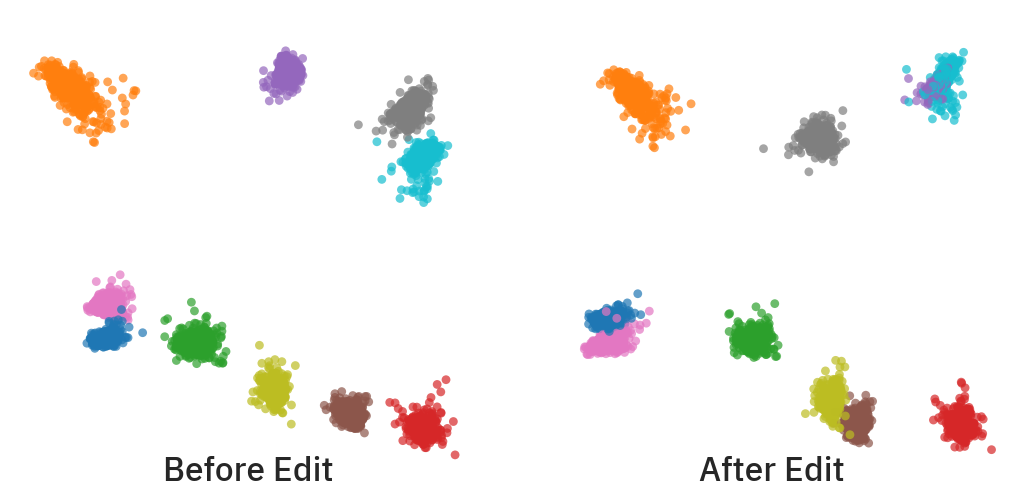

In [167]:
# Create figure and axis
fig = plt.figure(figsize=(10, 20), frameon=False)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0)

sub = 10_000

# Plot on the axis
ax1 = fig.add_subplot(121, projection="3d")
ax1.scatter(
    og_reduced[:sub, 0],
    og_reduced[:sub, 1],
    og_reduced[:sub, 2],
    s=40,
    alpha=0.7,
    c=colors[:sub],
    edgecolors="none",
)

ax2 = fig.add_subplot(122, projection="3d")
ax2.scatter(
    new_reduced[:sub, 0],
    new_reduced[:sub, 1],
    new_reduced[:sub, 2],
    s=40,
    alpha=0.7,
    c=colors[:sub],
    edgecolors="none",
)

axes = [ax1, ax2]
title = ["Before Edit", "After Edit"]
for i, ax in enumerate(axes):
    kill_ticks(ax)
    kill_axes(ax)

    ax.margins(0, 0, 0)
    ax.view_init(elev=-270, azim=0)
    ax.set_box_aspect([1, 1, 1], zoom=1.5)
    ax.text2D(
        0.5, 0.01, title[i], fontsize=24, font=ibmplexsans, ha="center", transform=ax.transAxes
    )

plt.savefig("edited.pdf", bbox_inches="tight", pad_inches=0, transparent=True)

Evaluate on test dataset

In [122]:
# # Build dataset
# test_dataset_config = DatasetConfig(
#     dataset_name=model_metadata["dataset"], num_samples=5_000, split="test", seed=42
# )
# DatasetClass = get_dataset_class(name=test_dataset_config.dataset_name)
# test_dataset = DatasetClass(config=test_dataset_config, root=data_root)
# test_labels = test_dataset.labels.squeeze()

# # Make dataloader
# batch_size = 5_000
# batch_size = min(subset_size, batch_size) if subset_size else batch_size
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# test_orig_act_dict, test_proc_act_dict, _ = prepare_acts(
#     data_train_loader=test_dataloader,
#     model=model,
#     device=device,
#     svd_dim=ae_metadata["in_features"],
#     whiten_alpha=preproc_dict["wh_alpha_0"],
#     preprocess=True,
#     preprocess_dict=preproc_dict,
#     only_first_last=True,
# )


# # Koopman intermediates
# test_intermediates = koopman_intermediates(
#     init_idx=init_idx,
#     final_idx=final_idx,
#     orig_act_dict=test_orig_act_dict,
#     proc_act_dict=test_proc_act_dict,
#     device=device,
#     preproc_dict=preproc_dict,
#     autoencoder=autoencoder,
#     model=model,
#     preprocess=True,
#     k_steps=k_steps,
# )

# pred = test_intermediates["pred"]
# x_proj_obs = test_intermediates["x_proj_obs"]

In [123]:
# # Per-class accuracy
# per_class_metric = MulticlassAccuracy(num_classes=dataset.out_features, average=None)
# per_class_metric.update(pred, test_labels.to(torch.long))
# print("Koopman accuracy per class (original):", per_class_metric.compute())

# # Overall accuracy
# overall_metric = MulticlassAccuracy(num_classes=dataset.out_features)
# overall_metric.update(pred, test_labels.to(torch.long))
# print("Overall Koopman accuracy:", overall_metric.compute())


In [124]:
# # Generate predictions with new operator
# with torch.no_grad():
#     new_pred_obs = x_proj_obs @ new_operator
#     new_pred = autoencoder.decode(new_pred_obs)
#     new_pred = undo_preprocessing_acts(new_pred, preproc_dict, final_idx, device)

#     new_pred = model.components[-1:](new_pred)

# # Per-class accuracy
# per_class_metric = MulticlassAccuracy(num_classes=dataset.out_features, average=None)
# per_class_metric.update(new_pred, test_labels.to(torch.long))
# print("Koopman accuracy per class:", per_class_metric.compute())

# # Overall accuracy
# overall_metric = MulticlassAccuracy(num_classes=dataset.out_features)
# overall_metric.update(new_pred, test_labels.to(torch.long))
# print("Overall Koopman accuracy:", overall_metric.compute())